In [32]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pattern_mining import EmailTemplateEncoder
from db.db import read_table, init_db, write_table, replace_table
from db.models import TableName
from pattern_mining import TemplateRuleMiner
from pattern_mining import DomainTemplateEncoder
from pattern_mining import add_name_characteristics_flags
from difflib import SequenceMatcher
from scipy.stats import entropy
from etl.transform import standardise_table
from pattern_mining import enrich_candidate_templates
from pattern_mining import build_f_t_map
from db import run_all_migrations

# Template Coverage Notebook

This notebook will cover in part the development as well as the result of the pattern mining phase. The intention is to use TRuleGrowth to mine for syntactic templates structures within the clean LP and GP datasets, with the focus being on the LP data.

# Encoding 

To implement our pattern miner we will be using the SPMF python library which wraps a Java implementation of the TRuleGrowth algorithm, the original implementation was done by Philippe Fournier-Viger who came up in the literature review where he did a comparative study of this algorithm as well as few others. This was the inspiration for this implementation. The wrapped call and underlying algorithm expects integer sequence inputs like such:
```markdown
1 2 3 -1
4 5 -1
1 5 6 3 -1
```
Where each line is a sequence delimited by a `-1`. Therefore, the first job is to convert our local email parts (e.g. `d.bowman` in `d.bowman@gmail.com`) into a set of human readable tokens. A token in this context consist of first name, last name, middle name, and the various initials. Some investor names may have double barrelled or multiple middle/last names and the encoder has tried to take this into account but part of this is to investigate how well our encoder responds to the given data. After tokenisation `d.bowman` should become `['f', '.', 'last']` where f represents the initial of a first name and last is the last name. We then need to encode these tokens with unique values so that we can feed it into TRuleGrowth. 

This is done by the `EmailTemplateEncoder` in the `_decompose_names` private method.

```python
    # Decompose name with name parser
    name = HumanName(full_name)
    # Return decomposition
    return {
        "first": name.first.lower(),
        "middle": name.middle.lower().replace("'", "").split(),
        "last": name.last.lower().replace("-", " ").split(),
        "initials": {
            "f": name.first.lower()[0],
            "m": [m.lower()[0] for m in name.middle.replace("'", "").split()]
            if name.middle
            else [],
            "l": [
                last_initial[0]
                for last_initial in name.last.lower().replace("-", " ").split()
            ]
            if name.last
            else [],
        },
    }
```

We then iterate through the associated email and try to match tokens to the contents of the local part before encoding and building our various lookup tables. Any unmatched contents will be marked 'UNK' and flagged in the class for us to inspect.
```python
# Update stats
self.stats["total"] += 1
if "UNK" in tokens:
    self.stats["unk_sequences"].append(lp)
```

Lets begin by loading our clean data.

In [33]:
# Initialise database engine
init_db()

# Read cleaned LP data
lp_df = read_table(TableName.LP_CLEAN)

Tables created successfully.
Read LP_CLEAN table from database!


Now lets unpack initialize our email encoder and let it run.

In [34]:
ete = EmailTemplateEncoder()
token_seqs = ete.encode_dataframe(lp_df)

Email Token Encoder Initialised!
Tokenised 0 out of 72310
Tokenised 5000 out of 72310
Tokenised 10000 out of 72310
Tokenised 15000 out of 72310
Tokenised 20000 out of 72310
Tokenised 25000 out of 72310
Tokenised 30000 out of 72310
Tokenised 35000 out of 72310
Tokenised 40000 out of 72310
Tokenised 45000 out of 72310
Tokenised 50000 out of 72310
Tokenised 55000 out of 72310
Tokenised 60000 out of 72310
Tokenised 65000 out of 72310
Tokenised 70000 out of 72310


In [35]:
print(len(ete.stats["unk_sequences"]))
ete.stats["unk_sequences"]

8


[[{'first': ['robert'], 'middle': [], 'last': ['fauntleroy']},
  'bobby.fauntleroy'],
 [{'first': ['edward'], 'middle': [], 'last': ['ambrose']}, 'eddie'],
 [{'first': ['daniel'], 'middle': [], 'last': ['hendrix']}, 'danny'],
 [{'first': ['daniel'], 'middle': [], 'last': ['diaz']}, 'danny.diaz'],
 [{'first': ['daniel'], 'middle': [], 'last': ['harkin']}, 'danny.harkin'],
 [{'first': ['robert'], 'middle': [], 'last': ['hamilton']}, 'bobby.hamilton'],
 [{'first': ['edward'], 'middle': [], 'last': ['carlisle']}, 'eddie.carlisle'],
 [{'first': ['daniel'], 'middle': [], 'last': ['flesch']}, 'dannyflesch']]

In [36]:
# Remove none sequences from df
lp_df = lp_df[lp_df["token_seq"].notna()].reset_index(drop=True)

It seems like there are lot of missing middle names in the dataset. With all that said, we still have a comprehensible list of encoded templates with just over 6000 missing, leaving us with over 70,000 still to mine. 

A few steps were taken to improve this and prune the unknowns. First, a nickname map was added to to map common nicknames to names found in the dataset, this allows to still find meaningful templates from the dataset. 
```python
# Add nickname variants
if string in NICKNAME_MAP:
    variants.update(NICKNAME_MAP[string])
```

This is especially useful as abbreviated names or different names (e.g. Dick, Bill) are largely down to personal preference rather than company policy to email structure. 

We also introduced a mapping to map Germanic or Dutch characters to email friendly variations to test against, we tree these variants as the same as the first name. 
```python
def _transliterate_german(self, s: str) -> str:
    """
    Replaces German-specific accented characters with ASCII transliterations.

    Args:
        s (str): The input string.

    Returns:
        str: A string with German characters replaced by ASCII equivalents.
    """
    for k, v in GERMAN_ASCII_MAP.items():
        s = s.replace(k, v)
    return s
```


We also normalize strings using NFKD to strip accents that are not commonly supported in emails.
```python
def _normalize_nfkd(self, s: str) -> str:
    """
    Applies NFKD Unicode normalization and strips accents producing
    an email safe, ASCII-only version of the string.

    Args:
        s (str): The input string.

    Returns:
        str: Normalized string.
    """
    return (
        unicodedata.normalize("NFKD", s)
        .encode("ascii", "ignore")
        .decode("ascii")
        .lower()
    )
```

Finally, surname particles often used in Danish, German and even French and other languages were polluting the dataset. This is problematic as these are often saved in the `investor` field as just, for example, "velden" whereas the email local part will use "vandervelden" with "vander" as surname particle. To combat this we enrich the name data with potential particles. 
```python
def _generate_last_name_variants(self, surname: str) -> List[str]:
    """
    Generates possible composite variants of a surname, especially for names that include
    particles or prefixes common in Dutch and German.

    This is useful when the email local-part uses a collapsed or joined form of the last name,
    such as 'velden' from 'vandervelden'.

    Args:
        surname (str): The raw last name string, possibly containing particles.

    Returns:
        List[str]: A sorted list of possible joined last name variants.
    """
    # Set to reduce redundancy
    variants = set()

    # Add each particle to the surname
    for particle in SURNAME_PARTICLES:
        variants.add(particle + surname)

    return sorted(variants, key=len, reverse=True)
```

Any sequence with an "UNK" found it has been thrown out to not affect our template miner. 

To expand our given templates, we also treat each variant type as its own token. This way we can produce a exhaustive list of possible token sequences to be our candidate templates in the LightGBM classifier. The classifier will then assign a probability of one of these templates being in the correct one, considering both the firm and investor name as well as other metadata including the output of TRuleGrowth and any other EDA we do from here. 

Let's see how many unique types there are.

In [37]:
unique_templates = {tuple(seq) for seq in token_seqs}
len(unique_templates)

404

With 404 we are left with a large cardinal feature space which is well suited for LightGBM. This will suit a poitnwise ranking model (similar to regression or binary classification per candidate) approach. We can define a set of features for each investor, where each row in the set is a template candidate sequence with various weighing features according to the frequency such a template is found for that firm, or for certain characteristics of the investors name, etc. This feature engineering will give us a rich feature space to train on.

# Rule Mining

Lets run our miner to see what templates dominate in the dataset.

In [38]:
tm = TemplateRuleMiner(ete, spmf_jar_dir="/home/d_bowman/documents/IRP/irp-db1724")
email_rules = tm.mine(token_seqs)
email_rules

>/home/d_bowman/documents/IRP/irp-db1724/spmf.jar
=============  TRULEGROWTH - STATS =============
Sequential rules count: 12
Total time : 4698 ms
Max memory (mb)368.5613327026367



[{'lhs_tokens': ['first_original_0'],
  'rhs_tokens': ['last_original_0'],
  'support': 29234,
  'confidence': 0.7346518231849822},
 {'lhs_tokens': ['first_original_0', '.'],
  'rhs_tokens': ['last_original_0'],
  'support': 27243,
  'confidence': 0.9618005295675198},
 {'lhs_tokens': ['first_original_0'],
  'rhs_tokens': ['last_original_0', '.'],
  'support': 27242,
  'confidence': 0.684592767572186},
 {'lhs_tokens': ['first_original_0'],
  'rhs_tokens': ['.'],
  'support': 28139,
  'confidence': 0.7071344206267434},
 {'lhs_tokens': ['first_original_0'],
  'rhs_tokens': ['l_0'],
  'support': 1062,
  'confidence': 0.02668811097429196},
 {'lhs_tokens': ['f_0'],
  'rhs_tokens': ['last_original_0'],
  'support': 27848,
  'confidence': 0.9329625783108312},
 {'lhs_tokens': ['f_0', '.'],
  'rhs_tokens': ['last_original_0'],
  'support': 1196,
  'confidence': 0.9439621152328335},
 {'lhs_tokens': ['f_0'],
  'rhs_tokens': ['last_original_0', '.'],
  'support': 1196,
  'confidence': 0.04006834399

Now that the mining is done, we can investigate the results. A dominant pattern is `'first_original_0'`-> `'last_original_0'` that appears 73% if the time in the dataset. Another is `'first_original_0''.'` -> `'last_original_0'` which appears 97% of the time in the 56784 cases it was mined from. This means that template like "johnsmith" and "john.smith" are strong rules for template prediction. There are also mined rules that feature initials like `'f0'` and `'l0'` which is valuable in terms of feature engineering. There are also rules that feature a secondary name, such as `'last_original_1'`, that could inform our engineered features.

We do not see any normalization tokens in the mined templates, probably because they occur far less commonly than given names. The next thing to do is further EDA on distribution of templates per firm, and name characteristics.

Using the `add_name_characteristics_flags` function we will flag a few key characteristics of an investors name that will affect the template used in the local email part. The characteristics we are flagging are;
```python
df["has_german_char"]
df["has_nfkd_normalized"]
df["has_nickname"]
df["has_multiple_first_names"]
df["has_middle_name"]
df["has_multiple_middle_names"]
df["has_multiple_last_names"]
```


In [39]:
flagged = add_name_characteristics_flags(lp_df)

Now that we have our flags, lets do some more EDA. First we'll take a look at which firms use which templates and how often. We'll count how many templates are used by firms and which template dominates per firm.

In [40]:
# Count how many templates each firm uses
template_counts_per_firm = (
    flagged.groupby("firm")["token_seq"].nunique().reset_index(name="num_templates")
)

# Firms using more than one template
firms_with_multiple_templates = template_counts_per_firm.query("num_templates > 1")

# Most common template per firm and its usage share
template_freq = (
    flagged.groupby(["firm", "token_seq"]).size().rename("count").reset_index()
)

# Add total template count per firm to compute share
total_by_firm = flagged.groupby("firm").size().rename("total").reset_index()

template_freq = template_freq.merge(total_by_firm, on="firm")
template_freq["share"] = template_freq["count"] / template_freq["total"]

# Get dominant template per firm
dominant_template_per_firm = (
    template_freq.sort_values(["firm", "share"], ascending=[True, False])
    .drop_duplicates("firm")
    .rename(columns={"token_seq": "top_template", "share": "top_template_share"})
    .loc[:, ["firm", "top_template", "top_template_share"]]
)

# Merge all insights
firm_template_summary = template_counts_per_firm.merge(
    dominant_template_per_firm, on="firm"
)
firm_template_summary.head(20).to_csv(
    "export/csv/firm_template_summary.csv", index=False
)
firm_template_summary

,firm,num_templates,top_template,top_template_share
0,0704 capital,1,"(f_0, last_original_0)",1.00
1,1 north wealth services,2,"(f_0, last_original_0)",0.80
2,10 branch,1,"(first_original_0,)",1.00
3,10 east,1,"(f_0, last_original_0)",1.00
4,1010 capital,1,"(first_original_0,)",1.00
...,...,...,...,...
14469,ålands mutual insurance company,1,"(first_nfkd_0, ., last_original_0)",1.00
14470,ícone investimentos,1,"(first_original_0, ., last_original_0)",1.00
14471,íslenski lífeyrissjóðurinn,3,"(first_nfkd_0, ., last_nfkd_0)",0.50
14472,österreichische beteiligungs,1,"(first_original_0, ., last_original_0)",1.00


So from a quick look at the top for the frame, it seems we have a lot of firms that follow a strict template structure. Let's visualize this with a histogram to see what the spread is like.

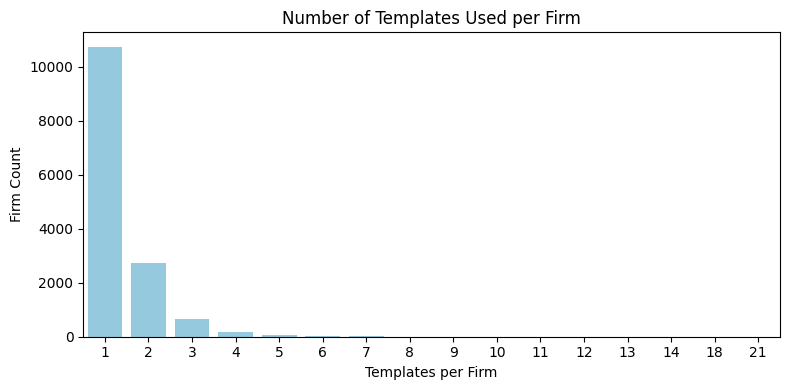

In [41]:
# Plot by templates per firm.
plt.figure(figsize=(8, 4))
sns.countplot(data=template_counts_per_firm, x="num_templates", color="skyblue")
plt.title("Number of Templates Used per Firm")
plt.xlabel("Templates per Firm")
plt.ylabel("Firm Count")
plt.tight_layout()
plt.savefig("export/figures/templates_per_firm.png", dpi=300)
plt.show()

So clearly most firms use only one template structure for email local parts with a long tail extending to as many as 21 template per firms. This distribution is pareto like with a positive skew. Indicating that most firms use a standard and easy to predict template pattern.

Let's look at which companies use more templates.

/tmp/ipykernel_427889/3885580854.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_firms, x="num_templates", y="firm", palette="viridis")


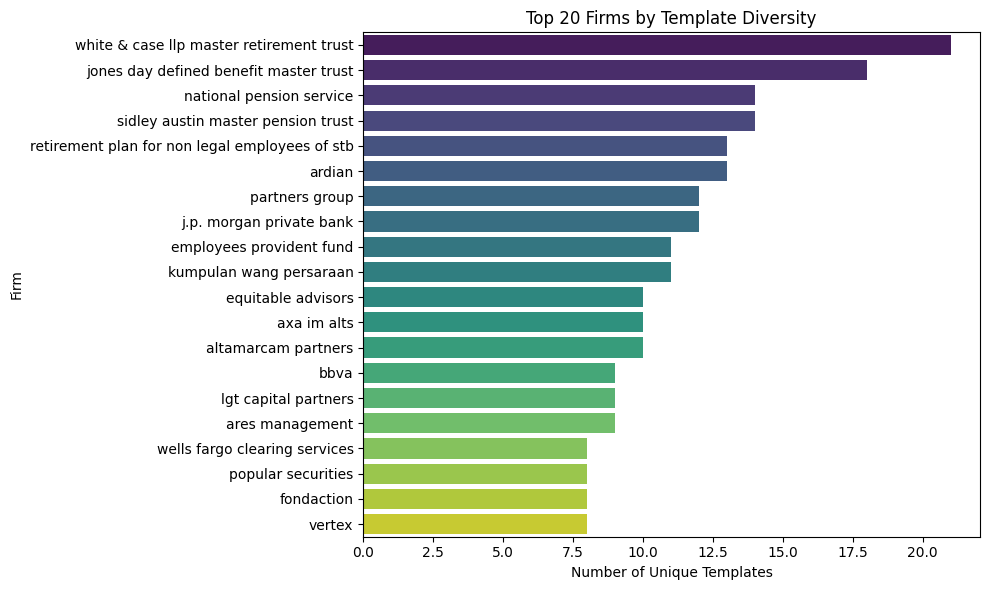

       num_templates
count   14474.000000
mean        1.377712
std         0.850784
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max        21.000000


In [42]:
top_firms = template_counts_per_firm.sort_values("num_templates", ascending=False).head(
    20
)

plt.figure(figsize=(10, 6))
sns.barplot(data=top_firms, x="num_templates", y="firm", palette="viridis")
plt.title("Top 20 Firms by Template Diversity")
plt.xlabel("Number of Unique Templates")
plt.ylabel("Firm")
plt.tight_layout()
plt.savefig("export/figures/top_20_firms_by_template_diversity.png", dpi=300)
plt.show()
print(template_counts_per_firm.describe())
template_counts_per_firm.describe().to_csv(
    "export/csv/template_counts_per_firm_summary.csv"
)

It seems like a lot of these are large and foreign/international firms. It would be interesting to see which firms have people in it with non ascii characters in their name, we can then look at if their investors have multiple middle or last names to see if they line up.

/tmp/ipykernel_427889/4277957988.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


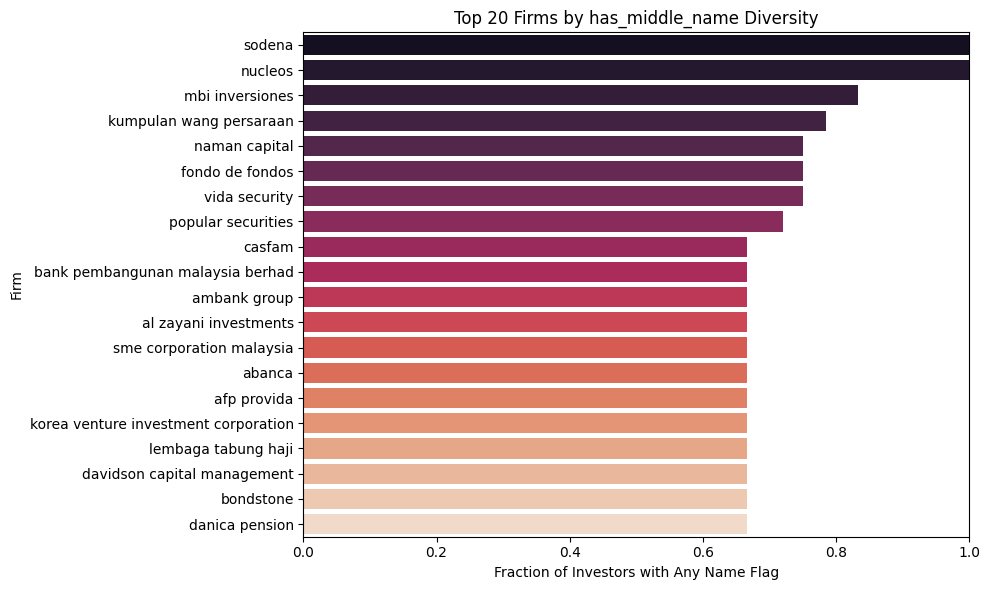

/tmp/ipykernel_427889/4277957988.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


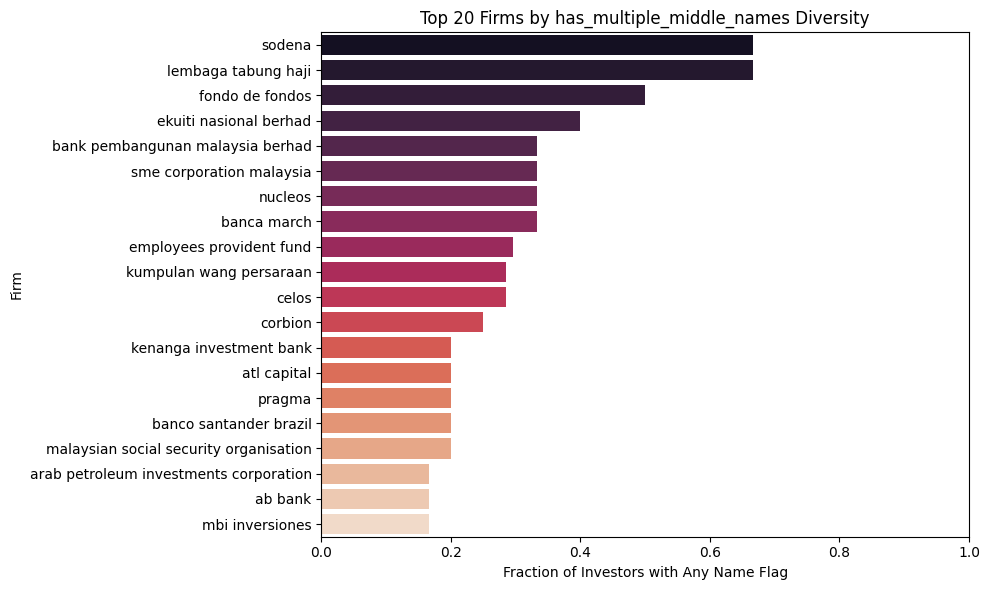

In [43]:
# Reusable function for different name flags
def plot_name_characteristic_firm_diversity(flag_field: str) -> None:
    # Compute percentage of the firm
    complexity_per_firm = (
        flagged.groupby("firm")[flag_field]
        .mean()
        .reset_index(name="complex_name_fraction")
    )

    # Prune for firms with at least one template
    multi_template_firms = template_counts_per_firm.query("num_templates > 2")["firm"]

    # Highlight complex firms
    top_complex_firms = (
        complexity_per_firm[complexity_per_firm["firm"].isin(multi_template_firms)]
        .sort_values("complex_name_fraction", ascending=False)
        .head(20)
    )

    # Plot hitogram to compare
    plt.figure(figsize=(10, 6))
    sns.barplot(
        data=top_complex_firms, x="complex_name_fraction", y="firm", palette="rocket"
    )
    plt.title(f"Top 20 Firms by {flag_field} Diversity")
    plt.xlabel("Fraction of Investors with Any Name Flag")
    plt.ylabel("Firm")
    plt.xlim(0, 1)
    plt.tight_layout()

    # Save figure
    plt.savefig(f"export/figures/top_20_firms_{flag_field}_diversity.png", dpi=300)
    plt.show()


# Start with middle name
plot_name_characteristic_firm_diversity("has_middle_name")
plot_name_characteristic_firm_diversity("has_multiple_middle_names")

/tmp/ipykernel_427889/4277957988.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


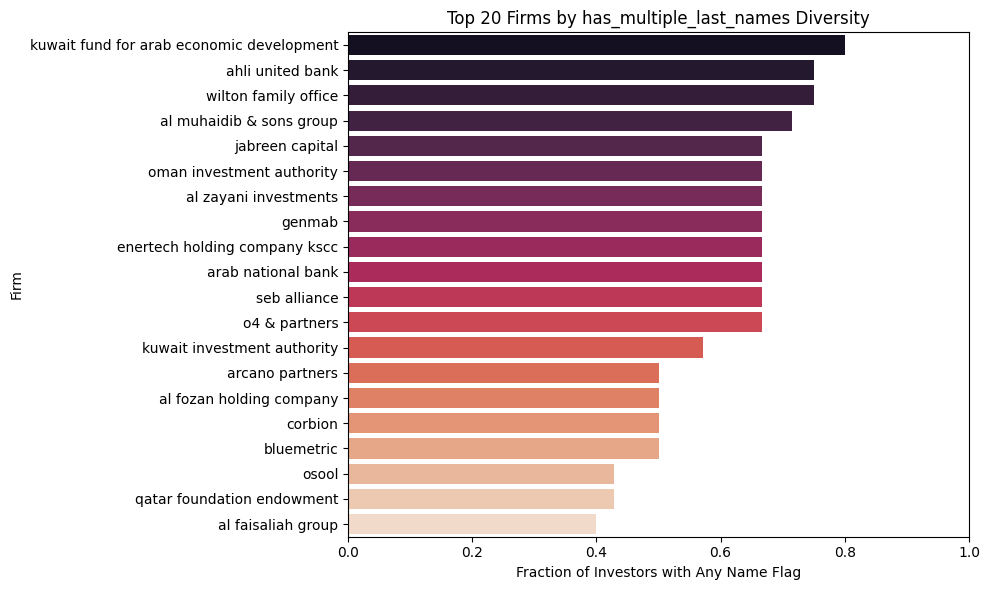

/tmp/ipykernel_427889/4277957988.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


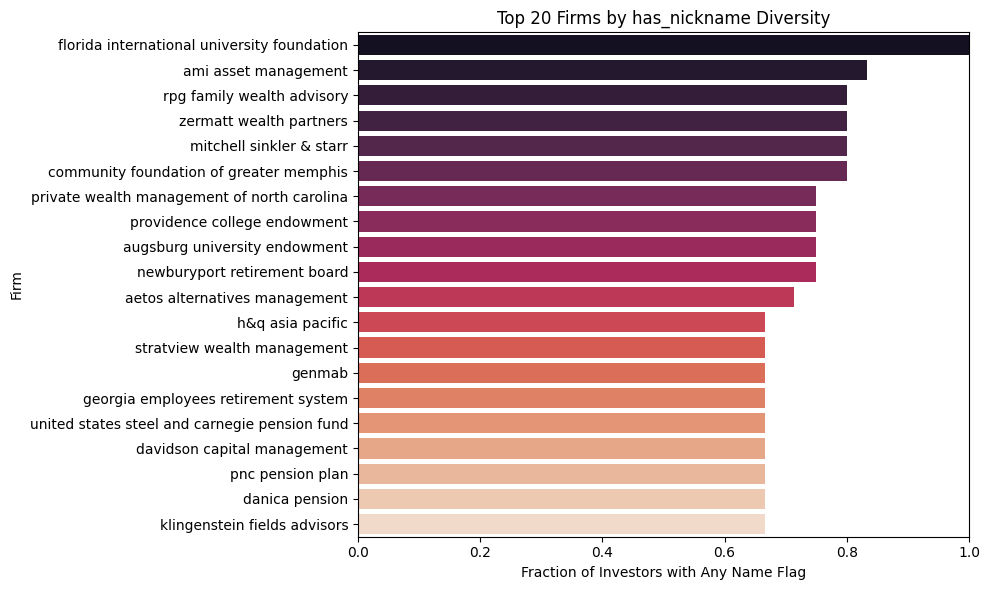

In [44]:
plot_name_characteristic_firm_diversity("has_multiple_last_names")
plot_name_characteristic_firm_diversity("has_nickname")

Basically no correlation here. Lets make this simpler by looking at a correlation matrix to try and answer whether firms with more than one template use complex name characteristics.

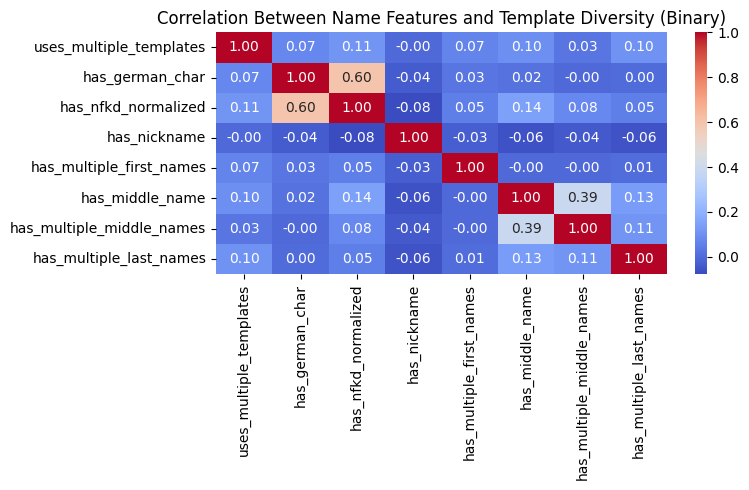

In [45]:
# Aggregate by firm
name_flags = [
    "has_german_char",
    "has_nfkd_normalized",
    "has_nickname",
    "has_multiple_first_names",
    "has_middle_name",
    "has_multiple_middle_names",
    "has_multiple_last_names",
]
agg_flags_per_firm = flagged.groupby("firm")[name_flags].mean().reset_index()

# Mark firms with multiple templates
template_counts_per_firm["uses_multiple_templates"] = (
    template_counts_per_firm["num_templates"] > 1
)
merged = template_counts_per_firm.merge(agg_flags_per_firm, on="firm")

# Compute correlation matrix
corr = merged[["uses_multiple_templates"] + name_flags].corr()

# Plot
plt.figure(figsize=(8, 5))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Between Name Features and Template Diversity (Binary)")
plt.tight_layout()
plt.savefig("export/figures/name_feature_template_diversity_correlation.png", dpi=300)
plt.show()

Ok so we see a slight positive correlation for nfkd normalization, but it is weak. This might be due to the majority of the firms in the dataset largely only using one template structure. Let's instead compare the distributions directly.

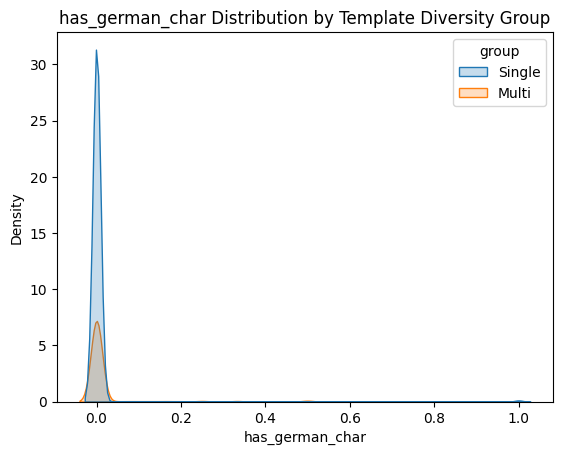

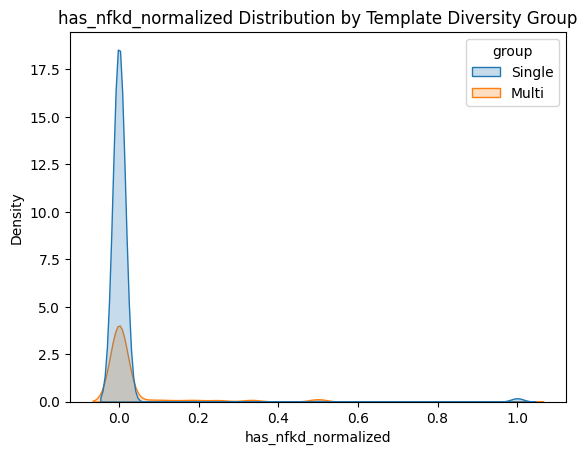

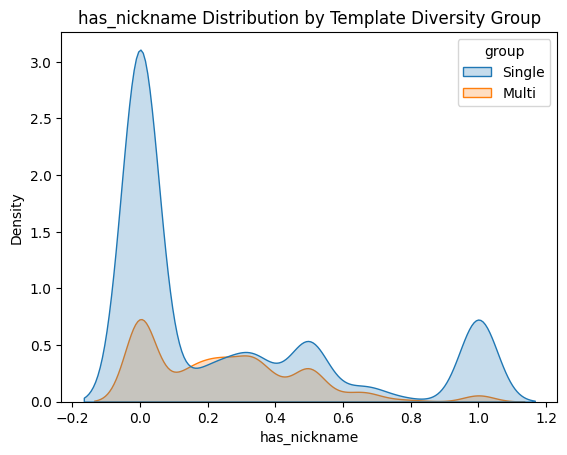

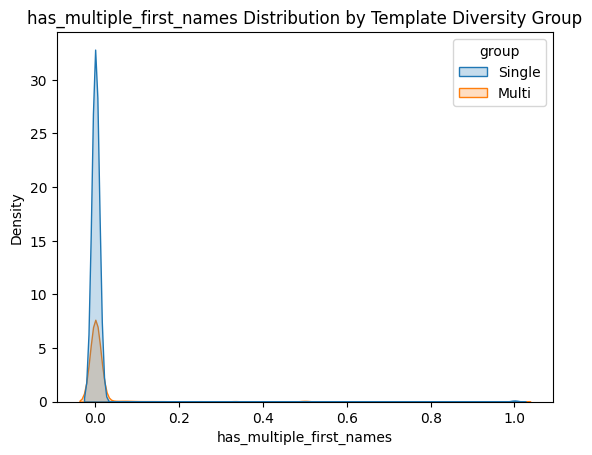

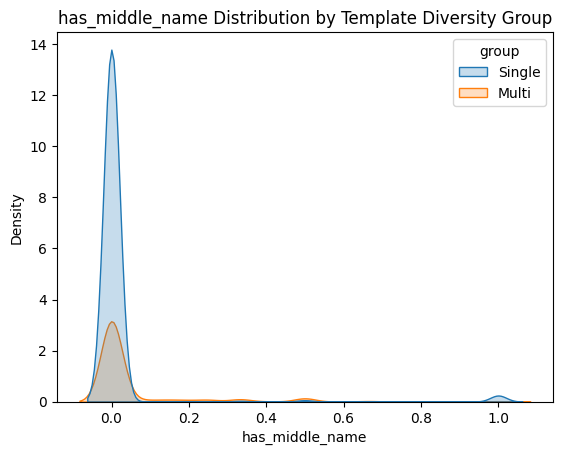

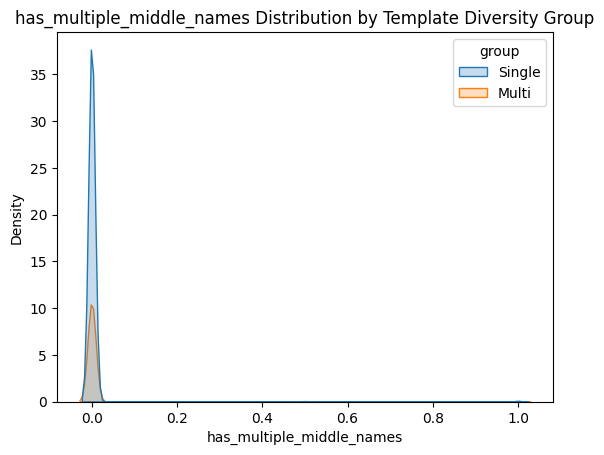

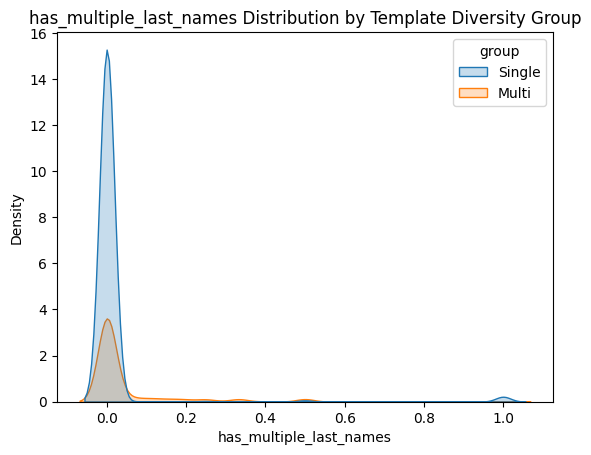

In [46]:
# Map single and multi template usage
merged["group"] = merged["uses_multiple_templates"].map(
    {True: "Multi", False: "Single"}
)

# Visualize estimated PDF
for flag in name_flags:
    sns.kdeplot(data=merged, x=flag, hue="group", fill=True)
    plt.title(f"{flag} Distribution by Template Diversity Group")
    plt.savefig(f"export/figures/{flag}_template_diversity_kde.png", dpi=300)
    plt.show()

Ok this is more helpful, although largely tells us the same thing. The distributions for single template firms and multi template firms are largely the same with respect to the various flags. Maybe there is a relation between firm size (at least from what we can infer from the dataset) and template diversity.

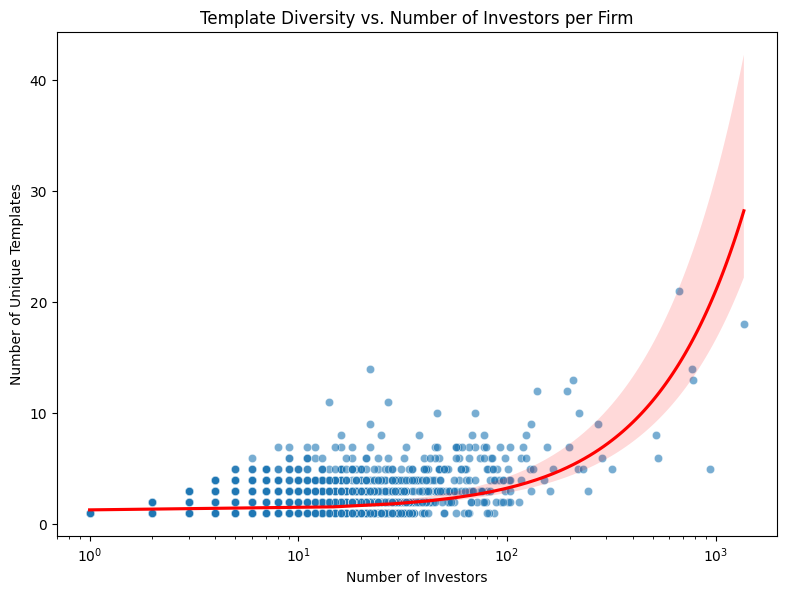

In [47]:
# Count number of investors per firm
firm_size = flagged.groupby("firm").size().reset_index(name="num_investors")

# Merge
firm_summary = firm_size.merge(template_counts_per_firm, on="firm")

# Plot loglog and fit a line through
plt.figure(figsize=(8, 6))
sns.scatterplot(data=firm_summary, x="num_investors", y="num_templates", alpha=0.6)
sns.regplot(
    data=firm_summary, x="num_investors", y="num_templates", scatter=False, color="red"
)
plt.title("Template Diversity vs. Number of Investors per Firm")
plt.xlabel("Number of Investors")
plt.ylabel("Number of Unique Templates")
plt.tight_layout()
plt.xscale("log")
plt.savefig("export/figures/template_diversity_vs_investors_loglog.png", dpi=300)
plt.show()

So clearly the is a pretty decent relationship between investor count and template diversity, especially for larger firms. This would make a use full feature even if correlation is definitively proved rather suggested.

So from here we have a good idea of how we will construct our feature matrix. We have an idea of what affects our template diversity, we also have a good set of flags to indicate name diversity and a set of dominant rules. We can pair this with our knowledge of which firms use what templates to produce a set of weighted candidates paired with individual and firm level info to feed into our LightGBM ranking classifier.

For the sake of writing it down, here is a list of features that I believe we should be including per candidate sequence per investor:

- Each row = one `(investor, firm, candidate_template)` triple
    - `label = 1` if candidate matches actual template
    - `label = 0` otherwise
    -  We generate this for every investor, across all 404 candidate templates
- Based on our EDA, we've now identified a rich set of feature types:
    - Template-specific features:
        - `template_length`
        - `num_initials`, `num_full_names`
        - `has_dot`, `has_dash`, `has_underscore`
        - `template_in_trulegrowth_rules`
        - `template_confidence`
        - `template_support`
    - Name-structure match features:
        - `name_has_middle_name`
        - `template_uses_middle`
        - `template_matches_full_first`
        - `template_uses_multiple_last_names`
        - `name_has_nfkd_normalized`
        - `name_has_german_char`
        - `name_has_nickname`
        - `name_has_multiple_first_names`, etc.
    - Firm/domain usage features:
        - `firm_template_share`
        - `firm_template_count`
        - `domain_template_count`
        - `domain_template_rank` (frequency rank of template in domain)
        - `num_investors` (firm size — controls for observation count)
        - `diversity_ratio` (num_templates / num_investors — signals fragmentation)
    - Rule-based and mined patterns:
        - Use of TRuleGrowth rules: whether template is in mined list
        - Rule confidence/support: how strongly this structure appears historically


In [48]:
dte = DomainTemplateEncoder()
flagged["domain"] = flagged["email"].str.extract(r"@([a-zA-Z0-9\.\-]+)")
token_seqs = dte.encode_dataframe(flagged)

Domain Token Encoder Initialised!
Tokenised 0 out of 72302
Tokenised 0 out of 72302
Tokenised 5000 out of 72302
Tokenised 10000 out of 72302
Tokenised 15000 out of 72302
Tokenised 20000 out of 72302
Tokenised 25000 out of 72302
Tokenised 30000 out of 72302
Tokenised 30000 out of 72302
Tokenised 30000 out of 72302
Tokenised 30000 out of 72302
Tokenised 30000 out of 72302
Tokenised 30000 out of 72302
Tokenised 30000 out of 72302
Tokenised 30000 out of 72302
Tokenised 30000 out of 72302
Tokenised 35000 out of 72302
Tokenised 40000 out of 72302
Tokenised 45000 out of 72302
Tokenised 50000 out of 72302
Tokenised 55000 out of 72302


To combat inconsistencies in firm name to domain mappings, we have included a few suffixes and normalizations to expand our coverage.

```python
# Define common suffices for investment firms
INVESTMENT_SUFFIXES = ["management", "mgmt", "group", "group", "grp", "g", "capital", "cap" "partners",
                       "prtnrs", "advisors", "advisory", "securities", "security" "investments", "investment",
                        "investors", "investor", "invest", "holdings", "holding"]

# Define common legal suffixes
LEGAL_SUFFIXES  = ["llc", "inc", "corp", "ltd", "plc", "co"]
```

We try to match these before given substrings to try and increase coverage. 

In [49]:
print(len(dte.stats["unk_sequences"]))
dte.stats["unk_sequences"]

13121


[['alba investment partners', 'albainvestments'],
 ['blue capital', 'bluecapitalwealth'],
 ['pursuit wealth management', 'myfirmllc'],
 ['4square advisory services', '4squareria'],
 ['warren financial', 'warrenfinancialplan'],
 ['van leeuwen retirement & investment services', 'lpl'],
 ['van leeuwen retirement & investment services', 'lpl'],
 ['van leeuwen retirement & investment services', 'lpl'],
 ['boelte ohara wealth management', 'yourwealthmgt'],
 ['table financial planning', 'thetablefinancialplanning'],
 ['bleidorn tax & investment services', 'bleidorncpa'],
 ['copper river advisors', 'crawealth'],
 ['ketron financial', 'rketron'],
 ['parkway wealth management group', 'parkwayteam'],
 ['parkway wealth management group', 'parkwayteam'],
 ['parkway wealth management group', 'parkwayteam'],
 ['atis', 'atiswealth'],
 ['atis', 'atiswealth'],
 ['atis', 'atiswealth'],
 ['cap 1 financial group', 'cap1tal'],
 ['buie investment advisors', 'bellsouth'],
 ['keller financial group', 'kellercp

In [50]:
unique_domain_templates = {tuple(seq) for seq in token_seqs}
len(unique_domain_templates)

939

Despite this we still have a lot of unmatched tokens. Largely due to other information that is missing from the firm name, such as location or shared domain idiosyncrasies.

Lets run the TRuleGrowth on our current tokens to try to see if any patterns dominate.

In [51]:
tm = TemplateRuleMiner(dte, spmf_jar_dir="/home/d_bowman/documents/IRP/irp-db1724")
tm.mine(token_seqs, minconf=0.5)

>/home/d_bowman/documents/IRP/irp-db1724/spmf.jar
=============  TRULEGROWTH - STATS =============
Sequential rules count: 7
Total time : 4900 ms
Max memory (mb)355.1604766845703



[{'lhs_tokens': ['0', '-'],
  'rhs_tokens': ['1'],
  'support': 1195,
  'confidence': 0.6112531969309463},
 {'lhs_tokens': ['0', '1_sub_1'],
  'rhs_tokens': ['2_sub_1'],
  'support': 2471,
  'confidence': 0.8648932446622332},
 {'lhs_tokens': ['-'],
  'rhs_tokens': ['1'],
  'support': 1229,
  'confidence': 0.5265638389031705},
 {'lhs_tokens': ['1_sub_1'],
  'rhs_tokens': ['2_sub_1'],
  'support': 5930,
  'confidence': 0.6684702964716492},
 {'lhs_tokens': ['1_sub_1', '0_sub_1'],
  'rhs_tokens': ['2_sub_1'],
  'support': 3181,
  'confidence': 0.555051474437271},
 {'lhs_tokens': ['0_sub_1'],
  'rhs_tokens': ['1_sub_1'],
  'support': 5552,
  'confidence': 0.7549632852869187},
 {'lhs_tokens': ['0_sub_1'],
  'rhs_tokens': ['2_sub_1'],
  'support': 4086,
  'confidence': 0.5556159912972531}]

Ok so one of the most dominant templates is `'0', '1_sub_1'` - > `'2_sub_1'`, which would look like "Blackstone Investment Group" -> "blackstoneig". We also see other templates like first initial followed by second initial, first word "-" second word. These are useful as they can guide our heuristic rules to construct unseen firms to domain mappings, but nothing here is definitive. In fact, the highest confidence we have is 82% for only 2434 cases with our already limited set of data that we were able to tokenize. So we can't really be informed in the same way that our email template rules will.

It would be interesting to see how different website (cleaned from for just the root) are from domain roots.

count    70982.000000
mean        92.175606
std         17.560297
min          4.900000
25%        100.000000
50%        100.000000
75%        100.000000
max        100.000000
Name: domain_similarity_pct, dtype: float64


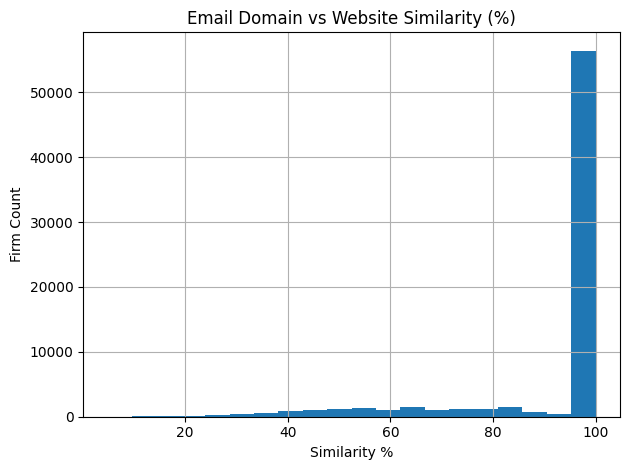

In [52]:
# Clean website url
flagged["website"] = (
    flagged["website"]
    .str.replace(r"^https?://", "", regex=True)
    .str.replace(r"^www\.", "", regex=True)
    .str.extract(r"^([^/]+)", expand=False)
    .str.lower()
    .str.strip()
)

# Compute similarity
flagged["domain_similarity"] = flagged.apply(
    lambda row: SequenceMatcher(None, row["domain"], row["website"]).ratio()
    if pd.notnull(row["domain"]) and pd.notnull(row["website"])
    else None,
    axis=1,
)

# To percentage
flagged["domain_similarity_pct"] = flagged["domain_similarity"].apply(
    lambda x: round(x * 100, 1) if pd.notnull(x) else None
)

# Print stats
valid_similarity = flagged[pd.notnull(flagged["domain_similarity_pct"])]
print(valid_similarity["domain_similarity_pct"].describe())

# Visual
valid_similarity["domain_similarity_pct"].hist(bins=20)
plt.title("Email Domain vs Website Similarity (%)")
plt.xlabel("Similarity %")
plt.ylabel("Firm Count")
plt.tight_layout()
plt.savefig("export/figures/domain_vs_website_similarity.png", dpi=300)
plt.show()

It seems we would be much better of inferring domain from website rather than mapping from the firm. It would be interesting to see what the domains with less than 50% similarity look like, I imagine it will be a shared domain or multi domain thing but lets look.

In [53]:
# Filter rows where similarity is < 50%
low_similarity = flagged[
    (pd.notnull(flagged["domain_similarity_pct"]))
    & (flagged["domain_similarity_pct"] < 50)
]

# Display top mismatches
low_similarity_examples = (
    low_similarity[
        [
            "firm",
            "website",
            "domain",
            "domain_similarity_pct",
            "firm_is_multi_domain",
            "is_shared_infra",
        ]
    ]
    .sort_values("domain_similarity_pct")
    .head(15)
)

low_similarity_examples

,firm,website,domain,domain_similarity_pct,firm_is_multi_domain,is_shared_infra
19280,sequoia foundation,sequoiafound.org,grantmakerconsultants.com,4.9,False,False
27418,new orleans sewerage & water board pension,swbno.org,marquetteassociates.com,6.2,True,True
27925,kalamazoo college endowment,kzoo.edu,cambridgeassociates.com,6.5,True,True
33963,occidental college endowment,oxy.edu,cambridgeassociates.com,6.7,True,True
27935,ohio wesleyan university endowment,owu.edu,cambridgeassociates.com,6.7,True,True
55789,illinois police officers pension investment fund,ipopif.org,verusinvestments.com,6.7,True,True
63246,brown shipley,brownshipley.com,merckfinck.de,6.9,True,True
39953,community foundation of greater memphis,cfgm.org,principalstreet.com,7.4,True,False
68026,kansas public employees retirement system,kspers.gov,townsendgroup.com,7.4,True,True
45162,ufcw union pension plan,ufcw.org,bgbenefitsadmin.com,7.4,False,False


Ok seems like there might be a relation. Lets see what percentage of the time are these domain flags are set for matching and non matching domains.

In [54]:
# Create boolean flag for perfect match
flagged["domain_similarity_is_perfect"] = flagged["domain_similarity_pct"] == 100
flagged["either_flag"] = flagged["firm_is_multi_domain"] | flagged["is_shared_infra"]
flagged["both_flags"] = flagged["firm_is_multi_domain"] & flagged["is_shared_infra"]
flagged["neither_flags"] = (~flagged["firm_is_multi_domain"]) & (
    ~flagged["is_shared_infra"]
)

# Group by domain match status
breakdown = (
    flagged.groupby("domain_similarity_is_perfect")[
        [
            "firm_is_multi_domain",
            "is_shared_infra",
            "either_flag",
            "neither_flags",
            "both_flags",
        ]
    ].mean(numeric_only=True)
    * 100
)  # convert to percentages

breakdown = breakdown.rename(columns={True: "Perfect Match", False: "<100% Match"}).T

# Save breakdown summary to CSV
breakdown.to_csv("export/csv/domain_match_flag_breakdown.csv")

# Display the summary
print(breakdown)

domain_similarity_is_perfect      False      True 
firm_is_multi_domain          47.606216  20.287874
is_shared_infra               30.561474  18.665696
either_flag                   61.122948  33.542170
neither_flags                 38.877052  66.457830
both_flags                    17.044742   5.411401


So clearly there is som relation between these flags and non-matching website and domain roots. This implies that our non matching domains are likely due to one of these flags. 

The main takeaway is that mapping website to domain is more reliable than firm name when it comes to resolving domains for unseen firms. Problematically, website will not be available at inference time which makes things difficult. From what I understand AIP accepts that unseen firm will be almost impossible to predict, so this is expected to be a rare or edge cases. With that in mind a RAG llm prompt with a web search context might be the best bet here. Where we find the company website for an unseen firm name? Will have to cross that bridge when we come to it.

As a sanity check lets look at the coverage of both our templates.

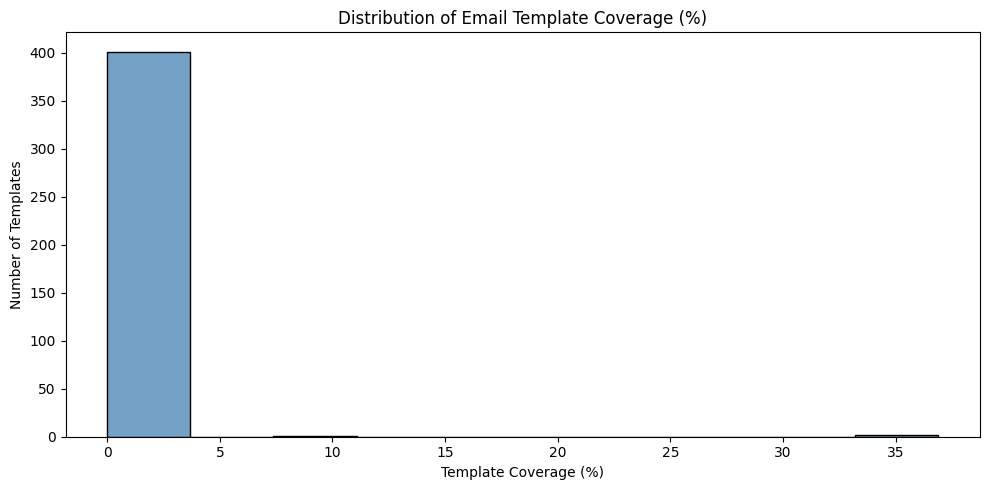

In [55]:
# Convert unique templates to readable templates
decoded_email_templates = set(
    tuple([ete.id_to_token[token] for token in seq]) for seq in unique_templates
)

# Get valid templates in flagged
email_seqs = flagged["token_seq"].dropna().apply(tuple)

# Precompute value counts of domain token sequences
email_seq_counts = email_seqs.value_counts()

# Total number of rows for percentage base
total_rows = len(email_seqs)

# Compute coverage for each template
template_coverage_list = [
    (email_seq_counts.get(tpl, 0) / total_rows) * 100 for tpl in decoded_email_templates
]

# Plot
plt.figure(figsize=(10, 5))
sns.histplot(template_coverage_list, bins=10, kde=False, color="steelblue")
plt.title("Distribution of Email Template Coverage (%)")
plt.xlabel("Template Coverage (%)")
plt.ylabel("Number of Templates")
plt.tight_layout()
plt.savefig("export/figures/email_template_coverage_distribution.png", dpi=300)
plt.show()

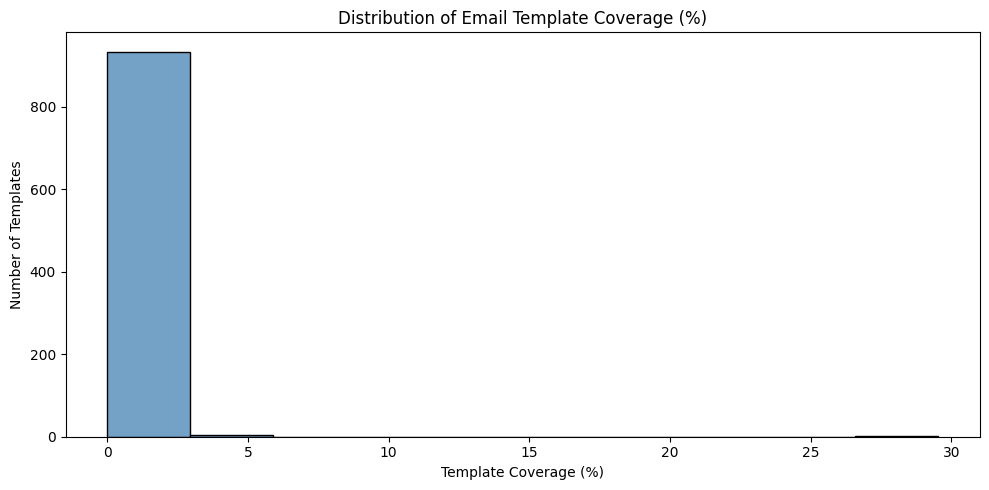

In [56]:
# Convert unique templates to readable templates
decoded_domain_templates = set(
    tuple([dte.id_to_token[token] for token in seq]) for seq in unique_domain_templates
)

# Get valid templates in flagged
domain_seqs = flagged["domain_token_seq"].dropna().apply(tuple)

# Precompute value counts of domain token sequences
domain_seq_counts = domain_seqs.value_counts()

# Total number of rows for percentage base
total_rows = len(domain_seqs)

# Compute coverage for each template
template_coverage_list = [
    (domain_seq_counts.get(tpl, 0) / total_rows) * 100
    for tpl in decoded_domain_templates
]

# Sort and extract percentages only
sorted_percentages = sorted(template_coverage_list, reverse=True)

# Plot
plt.figure(figsize=(10, 5))
sns.histplot(sorted_percentages, bins=10, kde=False, color="steelblue")
plt.title("Distribution of Email Template Coverage (%)")
plt.xlabel("Template Coverage (%)")
plt.ylabel("Number of Templates")
plt.tight_layout()
plt.savefig("export/figures/domain_template_coverage_distribution.png", dpi=300)
plt.show()

So we see largely the same distribution, where the majority of templates are covering only a tiny percentage of the dataset and a vast majority being covered by only a few templates. The only difference is we have way more firm to domain templates and much smaller dataset.

Let's leave domain mappings for now and consider different field relationships with email templates. We'll start by grouping by `'role'` to see how templates are distributed through the different roles.

/tmp/ipykernel_427889/3267720312.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_fields, x="num_templates", y=field, palette="viridis")


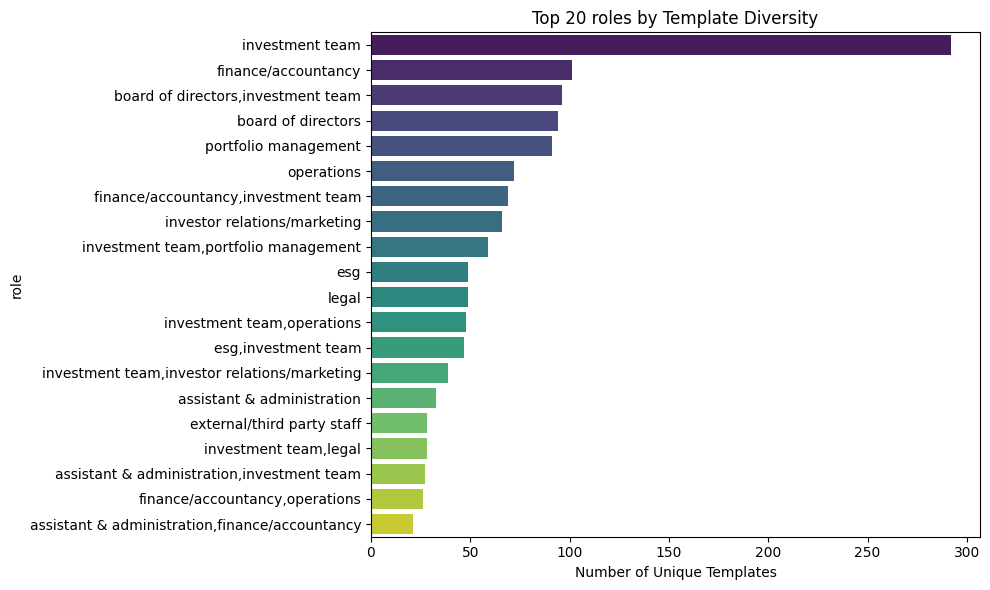

       num_templates
count     245.000000
mean        8.808163
std        24.124335
min         1.000000
25%         1.000000
50%         2.000000
75%         6.000000
max       292.000000


In [57]:
def highlight_template_diversity_in_field(field: str):
    # Number of unique templates per field
    template_counts_per_field = (
        flagged.groupby(field)["token_seq"].nunique().reset_index(name="num_templates")
    )

    # Most common template per field and its usage share
    template_freq_field = (
        flagged.groupby([field, "token_seq"]).size().rename("count").reset_index()
    )

    total_by_field = flagged.groupby(field).size().rename("total").reset_index()

    # Merge and get proportion
    template_freq_field = template_freq_field.merge(total_by_field, on=field)
    template_freq_field["share"] = (
        template_freq_field["count"] / template_freq_field["total"]
    )

    # Prune to top fields
    top_fields = template_counts_per_field.sort_values(
        "num_templates", ascending=False
    ).head(20)

    plt.figure(figsize=(10, 6))
    sns.barplot(data=top_fields, x="num_templates", y=field, palette="viridis")
    plt.title(f"Top 20 {field}s by Template Diversity")
    plt.xlabel("Number of Unique Templates")
    plt.ylabel(field)
    plt.tight_layout()
    plt.savefig(f"export/figures/top_20_{field}_template_diversity.png", dpi=300)
    plt.show()

    print(template_counts_per_field.describe())


highlight_template_diversity_in_field("role")

So template diversity in roles is quite significant. We have significant outliers (of 300 templates compared to only 20 for firms) and an average of 8.6 per role. It seems that firm is probably a clear identifier for template type. Lets compare with `'country'` to see if that affects anything.

/tmp/ipykernel_427889/3267720312.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_fields, x="num_templates", y=field, palette="viridis")


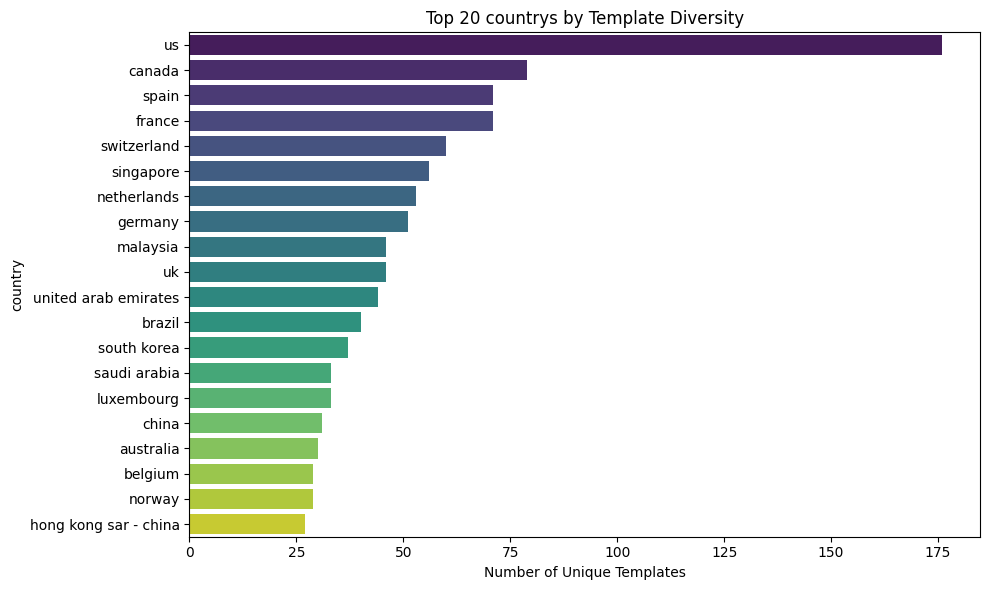

       num_templates
count     126.000000
mean       13.611111
std        21.926412
min         1.000000
25%         2.000000
50%         5.000000
75%        15.750000
max       176.000000


In [58]:
highlight_template_diversity_in_field("country")

Similar story here, we have a mean of 13 templates per country (with the US leading, not surprising since there is a lot of finance centres there) compared to the firm - template diversity which has a mean of 1.3 for a much larger count of 100000+.

Doesn't seem there is any meaningful feature engineering we can do here, lets track the entropy for the three fields to confirm this. 

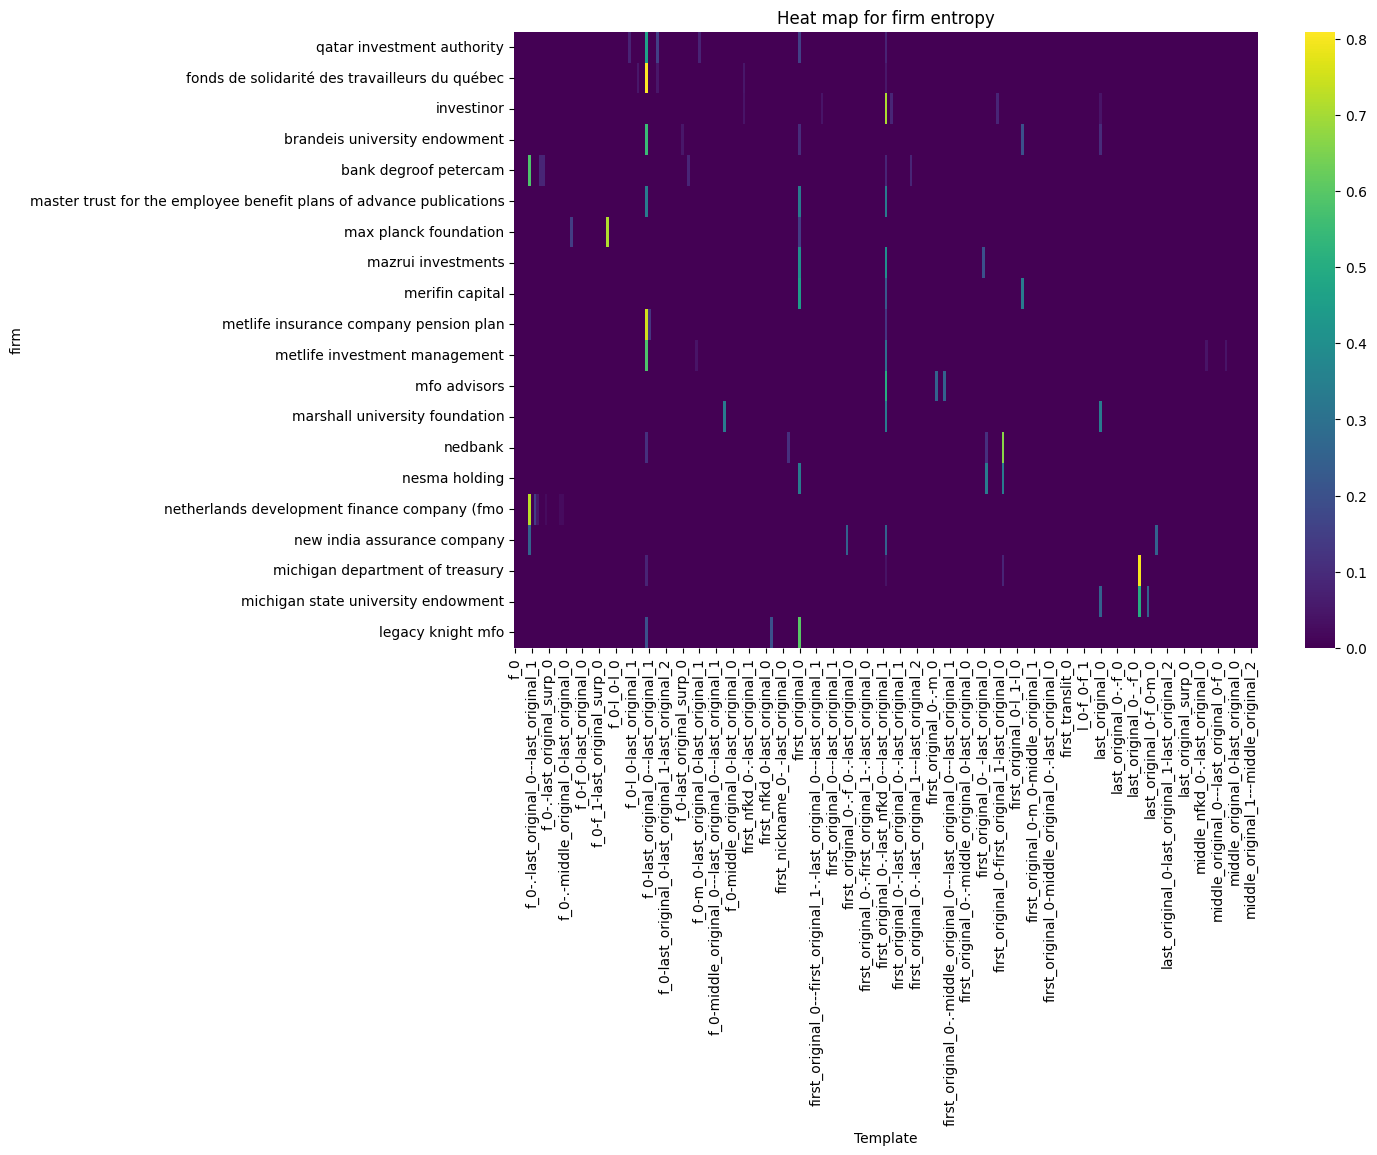

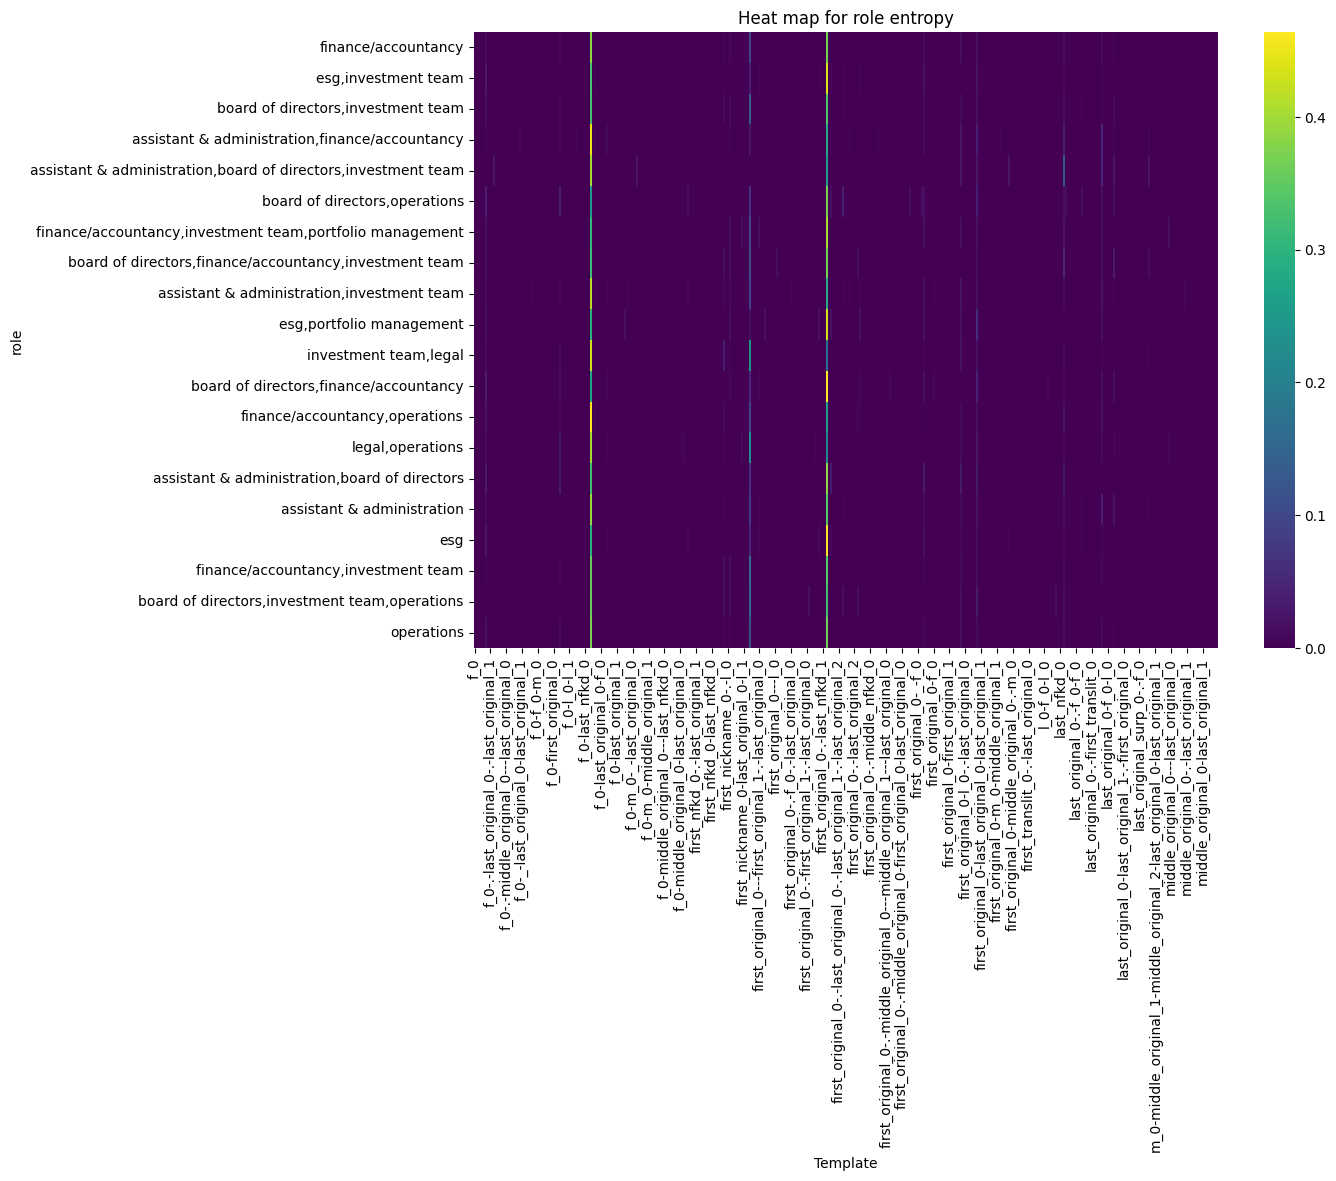

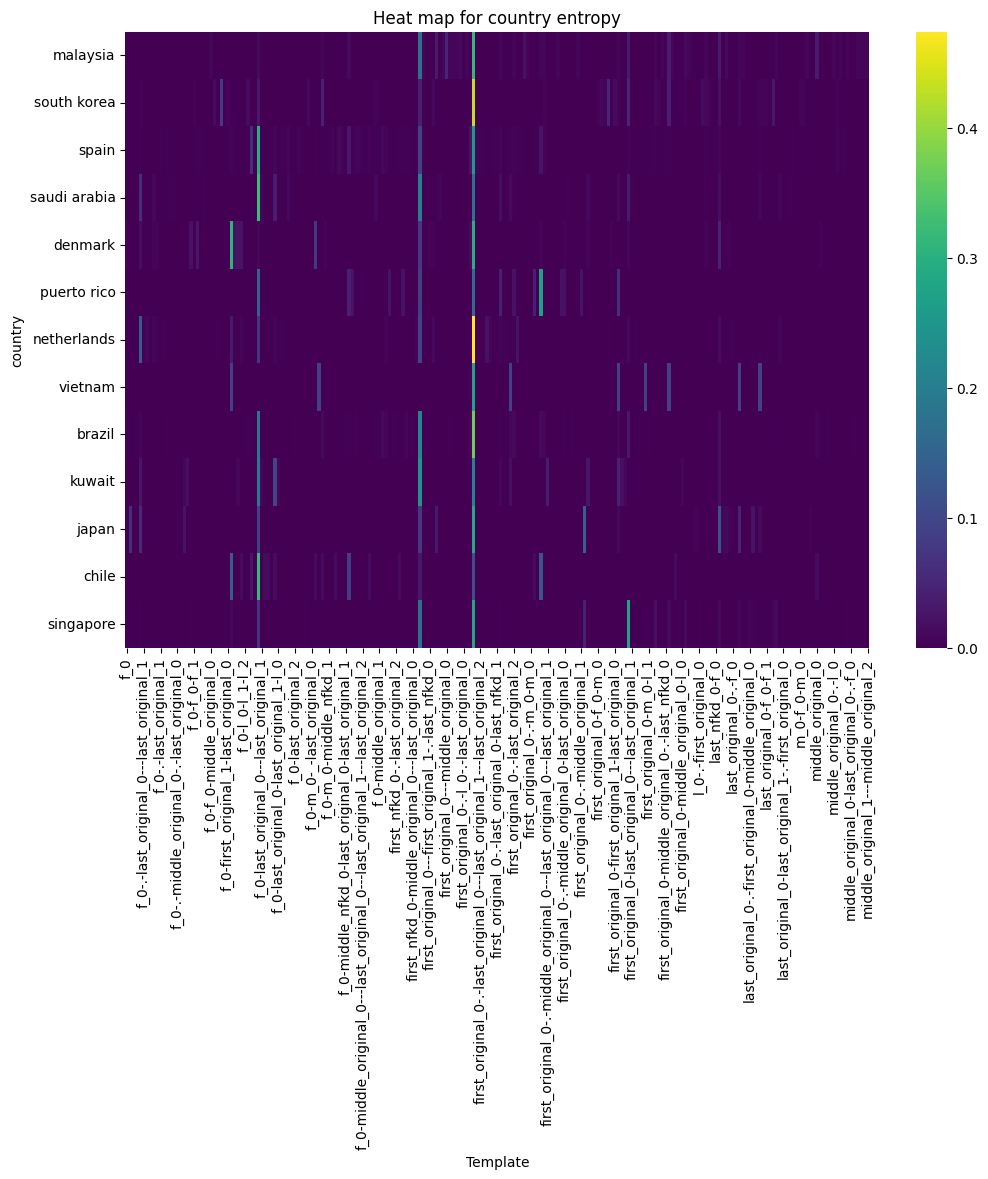

In [62]:
def calc_and_flag_entropy_and_heatmap(df, group_col):
    df = df.copy()
    df["token_seq_str"] = df["token_seq"].apply(lambda x: "-".join(x))
    # Calculate the entropy
    ctab = pd.crosstab(df[group_col], df["token_seq_str"], normalize="index").fillna(0)
    ent = ctab.apply(lambda row: entropy(row, base=2), axis=1)

    # Flag group with high entropy
    threshold = ent.quantile(0.9)
    high_entropy = ent[ent > threshold]

    # Plot the heatmap
    ctab = pd.crosstab(
        df.loc[df[group_col].isin(high_entropy.index)][group_col],
        df.loc[df[group_col].isin(high_entropy.index)]["token_seq_str"],
        normalize="index",
    ).fillna(0)
    top_groups = ctab.sum(axis=1).sort_values(ascending=False).head(20).index
    plt.figure(figsize=(12, 8))
    sns.heatmap(ctab.loc[top_groups], cmap="viridis")
    plt.ylabel(group_col)
    plt.title(f"Heat map for {group_col} entropy")
    plt.xlabel("Template")
    plt.savefig(f"export/figures/{group_col}_entropy_heatmap.png", dpi=300)
    plt.show()


# Calculate entropy per firm, role, country
calc_and_flag_entropy_and_heatmap(flagged, "firm")
calc_and_flag_entropy_and_heatmap(flagged, "role")
calc_and_flag_entropy_and_heatmap(flagged, "country")

Ok so there is a decent amount of diversity across the top firms, role and countries. The latter two seem to highlight more sparse patches of high entropy, where it is slightly more consistent for the firm case. The main take away is we see far more cases of low template diversity than we do high, although edge cases do permeate using our diverse feature set weighted from our mined rules we should be able to generalize well to them.

# Imputation

Let's attempt to impute some of our missing emails using the templates we know have 100% coverage in a firm. We'll start by getting all the firms that use only one template and finding what percentage of those firms are missing. We should be careful not to impute liberally on firms with a large amount of missing emails as we could be making unjustifiable assumptions. 

In [63]:
# Only include rows with a valid token_seq
valid_templates = flagged[flagged["token_seq"].notna()]

# Recalculate how many templates each firm uses
template_counts_per_firm = (
    valid_templates.groupby("firm")["token_seq"]
    .nunique()
    .reset_index(name="num_templates")
)

# Filter fir firms that only use one template
single_template_firms = template_counts_per_firm.query("num_templates == 1")["firm"]

# Read raw LP data to get missing rows
lp_raw_df = read_table(TableName.LP)

# Standardise investor names
lp_raw_df = standardise_table(lp_raw_df)
lp_raw_df

Read LP table from database!
Table Normalisation Complete!
Table Regex-Cleaning Complete!
Removed 18 bad investor rows!
Table Standardisation Complete!


,id,investor,firm_type,title,firm,alternative_name,role,job_title,asset_class,email,...,state,country,zip_code,linkedin,region,address,website,general_email,source_file,time_stamp
0,155963,noah rawlings,family office - single,None,1833,None,board of directors,president,gen,None,...,wy,us,82001,None,north america,2020 carey avenue suite 314,www.1833enterprises.com/,None,lp contact data,2025-07-01 22:00:10.655739
1,155962,stephen smith,wealth manager,mr,smith financial corporation,None,"board of directors,investment team",founder and chief executive officer,gen,None,...,None,canada,None,www.linkedin.com/in/stephen-smith-aa71a71b6/,north america,,www.smithfc.ca/,info@smithfc.ca,lp contact data,2025-07-01 22:00:10.655739
2,155961,joonas huttunen,investment company,mr,rake development company oy,None,investment team,chief investment officer,"pe,re",None,...,None,finland,00120,www.linkedin.com/in/joonas-huttunen/,europe,"bulevardi 6 b, 3krs",rake.fi/en/etusivu,None,lp contact data,2025-07-01 22:00:10.655739
3,155960,sijia wang,family office - multi,mr,oshen,None,None,managing partner,"pe,inf",None,...,None,luxembourg,1471,www.linkedin.com/in/peter-sijia-wang/,europe,"270, route desch",oshenbio.com/,info@oshenbio.com,lp contact data,2025-07-01 22:00:10.655739
4,155959,didier cowling,family office - multi,mr,oshen,None,None,managing partner,"pe,inf",None,...,None,luxembourg,1471,www.linkedin.com/in/lifesciencesexpert/,europe,"270, route desch",oshenbio.com/,info@oshenbio.com,lp contact data,2025-07-01 22:00:10.655739
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155958,5,george archer,fund manager,mr,3i,None,"finance/accountancy,investment team","partner, banking team","pe,inf,nr",george.archer@3i.com,...,None,uk,sw1x7lx,None,europe,1 knightsbridge,www.3i.com/,london@3i.com,lp contact data,2025-07-01 22:00:10.655739
155959,4,michael specht,fund manager,mr,3i,None,investment team,"partner, german private equity team","pe,inf,nr",michael.specht@3i.com,...,None,uk,60306,www.linkedin.com/in/michael-specht-0015a245/,europe,1 knightsbridge,www.3i.com/,london@3i.com,lp contact data,2025-07-01 22:00:10.655739
155960,3,david stephens,fund manager,mr,3i,None,investment team,partner & co-head of uk private equity team,pe,david.stephens@3i.com,...,None,uk,sw1x7lx,www.linkedin.com/in/david-stephens-31168911/,europe,1 knightsbridge,www.3i.com/,london@3i.com,lp contact data,2025-07-01 22:00:10.655739
155961,2,gaurav bhurat,fund manager,mr,3i,None,investment team,director,"pe,inf,nr",gaurav.bhurat@3i.com,...,None,uk,sw1x7lx,www.linkedin.com/in/gauravbhurat/,europe,1 knightsbridge,www.3i.com/,london@3i.com,lp contact data,2025-07-01 22:00:10.655739


In [64]:
# Get rows
lp_single_firm_rows = lp_raw_df[lp_raw_df["firm"].isin(single_template_firms)]

# Group by firm and compute missing email stats
email_missing_stats = (
    lp_single_firm_rows.groupby("firm")["email"]
    .agg(
        missing_email_count=lambda x: x.isna().sum(),
        non_missing_email_count=lambda x: x.notna().sum(),
        total_count=lambda x: len(x),
    )
    .reset_index()
)

# Calculate missing email percentage
email_missing_stats["missing_email_pct"] = (
    100
    * email_missing_stats["missing_email_count"]
    / email_missing_stats["total_count"]
)
# Save top 20 firms by missing email count
email_missing_stats.sort_values("missing_email_count", ascending=False).head(20).to_csv(
    "export/csv/top_20_firms_missing_emails.csv", index=False
)
email_missing_stats.sort_values("missing_email_count", ascending=False).head(20)

,firm,missing_email_count,non_missing_email_count,total_count,missing_email_pct
6235,"merrill lynch, pierce, fenner & smith",726,3,729,99.588477
3433,fidelity personal and workplace advisors,518,7,525,98.666667
1178,beacon pointe wealth advisors,297,37,334,88.922156
6477,morgan stanley wealth management,177,18,195,90.769231
913,avantax advisory services,155,9,164,94.512195
1272,bernstein private wealth management,154,65,219,70.319635
8536,sequoia financial group,145,6,151,96.026490
1847,cash balance retirement plan of brown brothers...,136,4,140,97.142857
9485,thrivent investment management,123,6,129,95.348837
7669,private advisor group,120,8,128,93.750000


Ok so there are clearly alot of sparse firms in this subset, lets look at the stats.

In [65]:
# Save summary statistics of email missingness
email_missing_stats.describe().to_csv("export/csv/email_missing_stats_summary.csv")
email_missing_stats.describe()

,missing_email_count,non_missing_email_count,total_count,missing_email_pct
count,10738.000000,10738.000000,10738.000000,10738.000000
mean,2.467685,3.072267,5.539952,29.073919
std,10.852767,4.066298,12.207106,29.848830
min,0.000000,1.000000,1.000000,0.000000
25%,0.000000,1.000000,2.000000,0.000000
50%,1.000000,2.000000,3.000000,25.000000
75%,2.000000,3.000000,6.000000,50.000000
max,726.000000,88.000000,729.000000,99.588477


So a few things to consider here, sparse firms with single templates would be unsuitable for imputation passed a certain threshold. Largely because we don't know enough about their template structures do to their missing emails. Secondly, total count is relevant - if we had a firm with 2 investors and one missing email, we could not reasonably assume that they would use the second email template for the second.

Lets try to refine this, we'll filter for missingness percent and total count using the statistics we are looking at.

In [66]:
# Conservative cutoffs based on 50 percentile
MAX_MISSING_PCT = 40
MIN_TOTAL_COUNT = 5

# Filter eligible firms for imputation
eligible_firms = email_missing_stats.query(
    "missing_email_pct <= @MAX_MISSING_PCT and missing_email_pct > 0 and total_count >= @MIN_TOTAL_COUNT"
)

print(eligible_firms["missing_email_count"].sum())
# Save summary statistics of eligible firms
eligible_firms.describe().to_csv("export/csv/eligible_firms_summary.csv")
eligible_firms.describe()

3100


,missing_email_count,non_missing_email_count,total_count,missing_email_pct
count,1308.000000,1308.000000,1308.000000,1308.000000
mean,2.370031,7.850153,10.220183,25.048382
std,2.096907,7.543834,8.970008,10.260943
min,1.000000,3.000000,5.000000,2.631579
25%,1.000000,4.000000,5.000000,16.666667
50%,2.000000,5.000000,7.000000,25.000000
75%,3.000000,9.000000,11.000000,33.333333
max,27.000000,88.000000,111.000000,40.000000


This looks like a good subset, just over 3000 investors across 1307 firms wil at least 5 total investors and no more than 40% of missing emails each. With this we have a good amount of imputation available to us. Lets save the firms to db so we can rerun our cleaning pipeline on the original data + imputations.

In [67]:
# Filter for eligible firm and nonna token seq
filtered = flagged[
    (flagged["firm"].isin(eligible_firms["firm"])) & (flagged["token_seq"].notna())
]

# Keep only the first valid token_seq per firm
deduped = filtered.drop_duplicates(subset="firm", keep="first")

# Convert token_seq from list/tuple to JSON string
deduped["template"] = deduped["token_seq"].apply(json.dumps)

# Select only required columns
firm_template_df = deduped[["firm", "template", "domain"]].copy()

# Write to database
# write_table(TableName.IMPUTATION_ELIGIBLE_FIRMS, firm_template_df)

/tmp/ipykernel_427889/1053186919.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  deduped["template"] = deduped["token_seq"].apply(json.dumps)


Now lets collect our candidate templates, enrich them with structural features and TRule matches for future feature engineering.

In [73]:
# Convert unique templates to string tokens
unique_templates_str = [ete.decode_token_sequence(seq) for seq in unique_templates]

# Build template lookup
template_lookup = {
    tuple(seq): idx for idx, seq in enumerate({tuple(s) for s in unique_templates_str})
}

# Convert template_lookup into DataFrame and enrich with mined rule info
candidate_df = enrich_candidate_templates(template_lookup, email_rules)

# Write to table
write_table(TableName.CANDIDATE_TEMPLATES, pd.DataFrame(candidate_df))

0 upserted, 404 inserted into CANDIDATE_TEMPLATES


404

These will be the foundation of our feature matrix, it will be enriched by name structures at inference as well as template coverage in the queried firm. To assist firm enrichment, we will store each firm with dominant template and coverage for that template in it to assist the model.

In [ ]:
# Build firm template lookup
firm_template_map_df = build_f_t_map(flagged, template_lookup)
firm_template_map_df

# Write to sql database
write_table(TableName.FIRM_TEMPLATE_MAP, firm_template_map_df)

,firm,num_investors,num_templates,diversity_ratio,is_single_template,template_ids
0,0704 capital,1,1,1.000000,True,[359]
1,1 north wealth services,5,2,0.400000,False,"[359, 368]"
2,10 branch,1,1,1.000000,True,[368]
3,10 east,1,1,1.000000,True,[359]
4,1010 capital,7,1,0.142857,True,[368]
...,...,...,...,...,...,...
14465,ålands mutual insurance company,1,1,1.000000,True,[73]
14466,ícone investimentos,1,1,1.000000,True,[176]
14467,íslenski lífeyrissjóðurinn,4,3,0.750000,False,"[268, 330, 368]"
14468,österreichische beteiligungs,1,1,1.000000,True,[176]


Now lets migrate our clean tables to include the new name structure flags, the new flags are `'has_german_char', 'has_nfkd_normalized', 'has_nickname','has_multiple_first_names', 'has_middle_name','has_multiple_middle_names', 'has_multiple_last_names']`. These will be used to build our feature matrix for training, they will enrich the candidate templates for more intelligent inference.

In [ ]:
# Migrate tables to new columns
run_all_migrations()

# Drop unneeded columns and save
columns_to_keep = [
    "id",
    "investor",
    "firm_type",
    "title",
    "firm",
    "alternative_name",
    "role",
    "job_title",
    "asset_class",
    "email",
    "tel",
    "city",
    "state",
    "country",
    "zip_code",
    "linkedin",
    "region",
    "address",
    "website",
    "general_email",
    "source_file",
    "is_shared_infra",
    "firm_is_multi_domain",
    "time_stamp",
    "has_german_char",
    "has_nfkd_normalized",
    "has_nickname",
    "has_multiple_first_names",
    "has_middle_name",
    "has_multiple_middle_names",
    "has_multiple_last_names",
    "token_seq",
]
cleaned_flagged_df = flagged[columns_to_keep].copy()

# Write
replace_table(TableName.LP_CLEAN, cleaned_flagged_df)

Column 'token_seq' already exists in 'lp_clean'.
Column 'is_shared_infra' already exists in 'lp_clean'.
Column 'firm_is_multi_domain' already exists in 'lp_clean'.
Column 'has_german_char' already exists in 'lp_clean'.
Column 'has_nfkd_normalized' already exists in 'lp_clean'.
Column 'has_nickname' already exists in 'lp_clean'.
Column 'has_multiple_first_names' already exists in 'lp_clean'.
Column 'has_middle_name' already exists in 'lp_clean'.
Column 'has_multiple_middle_names' already exists in 'lp_clean'.
Column 'has_multiple_last_names' already exists in 'lp_clean'.
Column 'token_seq' already exists in 'gp_clean'.
Column 'is_shared_infra' already exists in 'gp_clean'.
Column 'firm_is_multi_domain' already exists in 'gp_clean'.
Column 'has_german_char' already exists in 'gp_clean'.
Column 'has_nfkd_normalized' already exists in 'gp_clean'.
Column 'has_nickname' already exists in 'gp_clean'.
Column 'has_multiple_first_names' already exists in 'gp_clean'.
Column 'has_middle_name' alre

81727

This wraps up our pattern mining phase. I will construct the pipeline from this for mining templates, determining candidate templates, as well as flagging high coverage rule following templates for reusability.